### **IMAGEN 1**
**Objetivo**: contar cuántas células hay

Para empezar, descargamos los archivos que necesitamos desde Google Drive y los guardamos en el entorno de Colab con nuevos nombres.

In [ ]:
!pip install onedrivedownloader
from onedrivedownloader import download

CELL_ANTIGEN_IMG = 'https://universidadfv-my.sharepoint.com/:i:/g/personal/alberto_desantos_ufv_es/ESWcU3soWRFFhKUIBOoH2uUBZq6M5T5jrYA-cYK1YprwJg?e=LBz2yk'
CELL_SKIN_IMG = 'https://universidadfv-my.sharepoint.com/:i:/g/personal/alberto_desantos_ufv_es/EVq7WDpsmUdNpimem9qtc-0Btj8E9McUzg9IccKZN2f-rg?e=tNV0Dz'

download(url= CELL_ANTIGEN_IMG, filename='cell_antigen.png')
download(url= CELL_SKIN_IMG, filename='cell_skin.png')

'cell_skin.png'

Leemos las dos imágenes y las guardamos como variables image_1 y image_2. Después las mostramos:

/tmp/ipython-input-3570639696.py:4: FutureWarning: `imshow` is deprecated since version 0.25 and will be removed in version 0.27. Please use `matplotlib`, `napari`, etc. to visualize images.
  io.imshow(image_1)
/tmp/ipython-input-3570639696.py:5: FutureWarning: `show` is deprecated since version 0.25 and will be removed in version 0.27. Please use `matplotlib`, `napari`, etc. to visualize images.
  io.show()


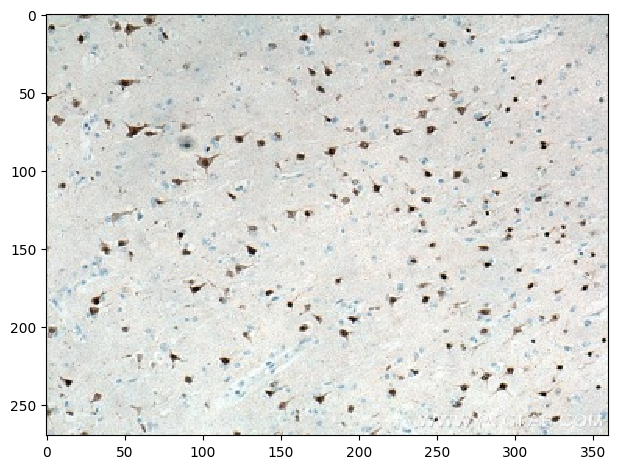

/tmp/ipython-input-3570639696.py:7: FutureWarning: `imshow` is deprecated since version 0.25 and will be removed in version 0.27. Please use `matplotlib`, `napari`, etc. to visualize images.
  io.imshow(image_2)
/tmp/ipython-input-3570639696.py:8: FutureWarning: `show` is deprecated since version 0.25 and will be removed in version 0.27. Please use `matplotlib`, `napari`, etc. to visualize images.
  io.show()


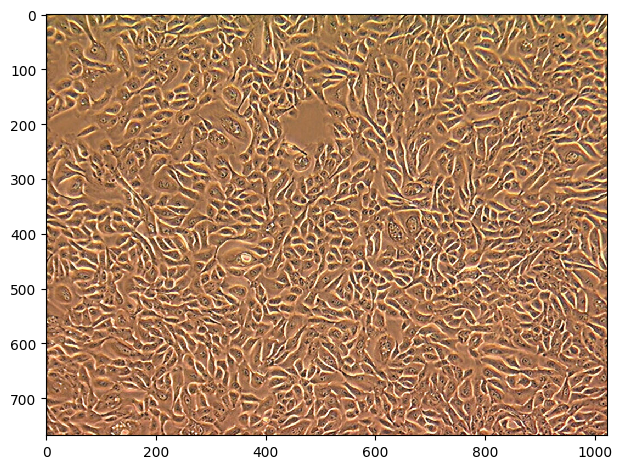

In [ ]:
from skimage import io

image_1 = io.imread('cell_antigen.png')
io.imshow(image_1)
io.show()
image_2 = io.imread('cell_skin.png')
io.imshow(image_2)
io.show()

El siguiente paso que haremos será aumentar la intensidad del color azul de la primera imagen para que las células se distingan mejor del fondo:

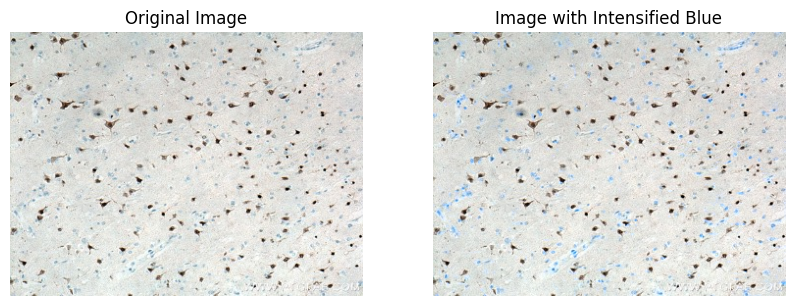

In [ ]:
#Importamos algunas librerías
import skimage.color #para cambiar el espacio de color de RGB a Lab
import numpy as np  #para hacer cálculos con matrices
import matplotlib.pyplot as plt #para mostrar gráficas

#Convertimos la imagen a valores entre 0 y 1 en vez de 0 a 255
image_to_intensify = skimage.img_as_float(image_1.copy())

#Cambiamos el espacio de color a Lab para modificar solo los tonos azules sin afectar a los demás tonos
image_lab = skimage.color.rgb2lab(image_to_intensify)

#Ajustamos la intensidad del azul. Si el número es muy grande podemos distorsionar otros colores, así que probamos con 4.
blue_intensity_factor = 4

#Encontramos los valores en el canal 'b', que corresponden al azul
negative_b_mask = image_lab[:, :, 2] < 0

# Multiplicamos los valores de azul por el factor de intensidad definido antes
image_lab[negative_b_mask, 2] *= blue_intensity_factor

# Convertimos la imagen otra vez a RGB para poder verla
image_intensified_blue_rgb = skimage.color.lab2rgb(image_lab)

# Mostramos la imagen original y la nueva para comparar
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(image_1) # La imagen original
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(image_intensified_blue_rgb) #La imagen modificada
plt.title("Image with Intensified Blue")
plt.axis('off')

plt.show()


Para contar las células debemos hacer lo siguiente:
1) Preparar la imagen para presentarla como píxeles que tienen 3 posibles valores: rojo, verde o azul. Así se convierten en datos que luego podemos agrupar
2) Convertir a otros espacios de color. Cada uno separa de forma distinta y algunos separan mejor los colores que nos interesan.
3) Agrupar los píxeles por similitud. En nuestro caso vamos a separar en tres: fondo, marrón y azul.
4) Hacemos máscaras con cada grupo (imágenes en blanco y negro solo con las zonas de cada color)
5) Usamos esas máscaras para contar

Shapes:
 RGB: (97200, 3)
 HSV: (97200, 3)
 Lab: (97200, 3)

--- RGB Clustering ---
RGB cluster labels shape: (97200,)

--- HSV Clustering ---
HSV cluster labels shape: (97200,)

--- Lab Clustering ---
Lab cluster labels shape: (97200,)

Performed RGB, HSV, and Lab clustering.


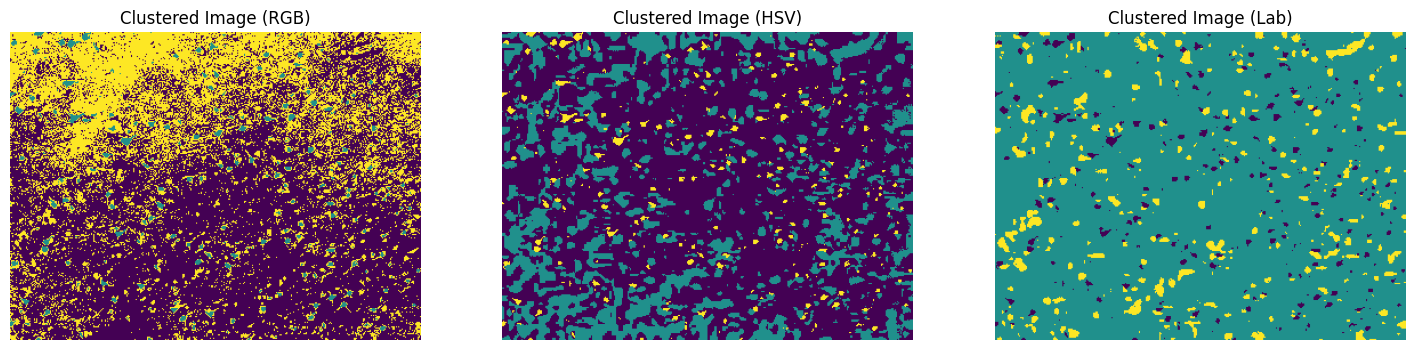


Cluster Centers (RGB):
[[0.89745069 0.89978703 0.88408513]
 [0.41981514 0.38949483 0.36042404]
 [0.80067602 0.80560914 0.79148555]]

Cluster Centers (HSV):
[[0.16177139 0.0311044  0.87717381]
 [0.50920982 0.06195014 0.87912052]
 [0.09796331 0.22619953 0.42465905]]

Cluster Centers (Lab):
[[-4.31646283  2.03397665  1.17881209]
 [ 0.17324027  0.00843877  0.17441407]
 [-0.39880989 -1.08152168 -3.01601577]]

Identified brown clusters (RGB): [1]
Identified blue clusters (Lab/HSV): [2]


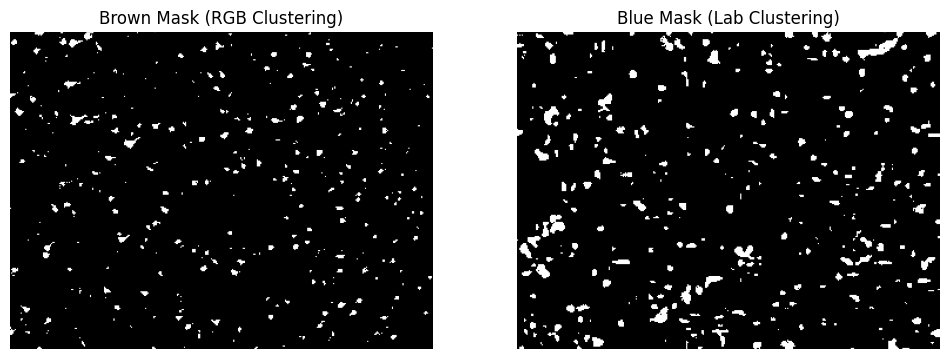

Number of cells (blue): 329
Number of antigens (brown): 364


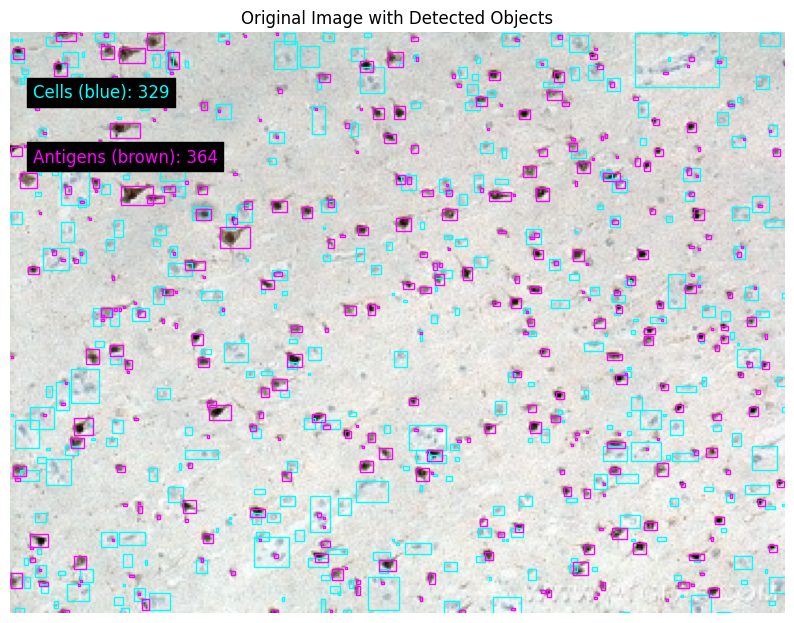

In [ ]:
#Importamos librerías
import numpy as np #Para hacer operaciones matemáticas y con matrices
import matplotlib.pyplot as plt #para mostrar imágenes y gráficos
import matplotlib.patches as patches #para dibujar formas sobre las imágenes
import skimage.color #para convertir a distintos espacios de color
import skimage.measure #para medir y analizar regiones dentro de imágenes
from sklearn.cluster import KMeans #para agrupar píxeles por color
from sklearn.preprocessing import StandardScaler #para normalizar los datos antes de agrupar y asegurarse que todos tienen el mismo peso en el clustering


#Convertimos la imagen a valores de 0 y 1 en vez de valores de 0 a 255
image_1 = skimage.img_as_float(image_1)

#Guarda las dimensiones de la imagen en número de filas, columnas y canales de color (RGB). Se usa para luego reconstruir imágenes
height, width, channels = image_1.shape

# Convierte la imagen en una tabla donde cada fila es un píxel y cada columna es un canal de color
pixel_data = image_1.reshape((-1, channels))

# Convertimos la imagen en dos espacios de color distintos
image_1_hsv = skimage.color.rgb2hsv(image_intensified_blue_rgb) #converir a hsc
image_1_lab = skimage.color.rgb2lab(image_intensified_blue_rgb) #convertir a lab

#Convertimos estas dos nuevas imagenes en tablas también
pixel_data_hsv = image_1_hsv.reshape((-1, 3))
pixel_data_lab = image_1_lab.reshape((-1, 3))

#Mostramos el tamaño de cada tabla de datos para ver que todo se ha hecho correctamente
print("Shapes:")
print(" RGB:", pixel_data.shape)
print(" HSV:", pixel_data_hsv.shape)
print(" Lab:", pixel_data_lab.shape)

#CLUSTERING RGB
print("\n--- RGB Clustering ---") #imprimir por pantalla que estamos haciendo el clustering de RGB
kmeans_rgb = KMeans(n_clusters=3, random_state=42, n_init=10) #creamos el modelo KMeans: 3 clusters porque queremos detectar 3 colores solo (fondo, azul, marrón), random state 42 es una selección
                                                              # aleatoria por la que empezamos todo el rato para que sea reproducible y cada vez que lo hagamos los datos no varíen porque empieza en otro sitio
                                                              # y n_init=10 para que se repita 10 veces y elija el mismo valor
pixel_labels_rgb = kmeans_rgb.fit_predict(pixel_data) #para entrenar al modelo con los datos de cada pixel y asignarlos al cluster correspondiente. El resultado es una lista larga de 0, 1 y 2 donde cada uno es un cluster
                                                      #correspondiente a cada color que queremos
print("RGB cluster labels shape:", pixel_labels_rgb.shape) #muestra el resultado total, que debe ser igual al número total de píxeles


# CLUSTERING HSV: hacemos exactamente lo mismo que antes pero con la imagen en HSV, que separa mejor el color del brillo
print("\n--- HSV Clustering ---")
kmeans_hsv = KMeans(n_clusters=3, random_state=42, n_init=10)
pixel_labels_hsv = kmeans_hsv.fit_predict(pixel_data_hsv)
print("HSV cluster labels shape:", pixel_labels_hsv.shape)


#CLUSTERING LAB: igual que los anteriores dos pero para este es necesario normalizar los valores primero porque en Lab puede que alguna capa predomine en importancia sobre otra
print("\n--- Lab Clustering ---")
scaler = StandardScaler() #normalizar los datos para que todos tengan media 0 y desviación 1
pixel_data_lab_scaled = scaler.fit_transform(pixel_data_lab)

kmeans_lab = KMeans(n_clusters=3, random_state=42, n_init=10)
pixel_labels_lab = kmeans_lab.fit_predict(pixel_data_lab_scaled)
print("Lab cluster labels shape:", pixel_labels_lab.shape)


print("\nPerformed RGB, HSV, and Lab clustering.")


# Visualización de los clusters: para ver como KMeans ha agrupado los píxeles. Así podemos visualizar cual de los 3 (RGB, HSV o Lab) ha separado mejor las células

plt.figure(figsize=(18, 6)) #determina el tamaño de la imagen

#Para convertir los datos del KMeans de nuevo a imágenes
clustered_image_rgb = pixel_labels_rgb.reshape((height, width)) #imagen RGB
clustered_image_hsv = pixel_labels_hsv.reshape((height, width)) #imagen HSV
clustered_image_lab = pixel_labels_lab.reshape((height, width)) #imagen Lab

#organiza las imágenes
#imagen RGB
plt.subplot(1, 3, 1) #primer número es la fila, segundo número son las columnas y tercer número es el número de imagen
plt.imshow(clustered_image_rgb, cmap='viridis') #usa una paleta de color falsa para que se vea mejor
plt.title("Clustered Image (RGB)") #añadir título
plt.axis('off') #quita ejes numéricos
#imagen HSV
plt.subplot(1, 3, 2)
plt.imshow(clustered_image_hsv, cmap='viridis')
plt.title("Clustered Image (HSV)")
plt.axis('off')
#imagen Lab
plt.subplot(1, 3, 3)
plt.imshow(clustered_image_lab, cmap='viridis')
plt.title("Clustered Image (Lab)")
plt.axis('off')

plt.show() #muestra las tres imágenes la una al lado de la otra


#Para imprimir por pantalla el color promedio de un grupo de píxeles. Viendo estos valores podemos estimar que color es
#Imagen en RGB
print("\nCluster Centers (RGB):")
print(kmeans_rgb.cluster_centers_)
#Imagen en HSV
print("\nCluster Centers (HSV):")
print(kmeans_hsv.cluster_centers_)
#Imagen en Lab
print("\nCluster Centers (Lab):")
print(kmeans_lab.cluster_centers_)


# IDENTIFICACIÓN DE CLUSTERS: asignamos manualmente qué numero de cluster representa cada color basándonos en los resultados anteriores.
#Así el programa sabrá que valores son marrones y cuales son azules
brown_cluster_labels = [1]  # El cluster 1 de los clusters en RGB tiene los colores marrones
blue_cluster_labels = [2]   # El cluster 2 de los clusters en Lab tiene los colores azules

#Imprimimos los valores
print(f"\nIdentified brown clusters (RGB): {brown_cluster_labels}")
print(f"Identified blue clusters (Lab/HSV): {blue_cluster_labels}")


#Creamos las máscaras: dos imágenes en blanco y negro donde solo se ven las zonas que son marrones o solo las que son azules
#np.isin devuelve True si los píxeles pertenecen a los clusters indicados
brown_mask_clustered = np.isin(pixel_labels_rgb, brown_cluster_labels) #será True(blanco) para los píxeles marrones y False(negro) para el resto
blue_mask_clustered = np.isin(pixel_labels_lab, blue_cluster_labels) #lo mismo pero con los píxeles azules

#Converitmos las largas listas de datos en imágenes 2D del mismo tamaño que la original
brown_mask_clustered_reshaped = brown_mask_clustered.reshape((height, width))
blue_mask_clustered_reshaped = blue_mask_clustered.reshape((height, width))

#Mostramos la máscara marrón
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(brown_mask_clustered_reshaped, cmap='gray') #cmap=gray indica que se usan escalas de grises para la imagen: blanco(área detectada) y negro(fondo)
plt.title("Brown Mask (RGB Clustering)")
plt.axis('off')

#Mostramos la máscara azul
plt.subplot(1, 2, 2)
plt.imshow(blue_mask_clustered_reshaped, cmap='gray')
plt.title("Blue Mask (Lab Clustering)")
plt.axis('off')
plt.show()


#CONTEO DE CÉLULAS
#label asigna un número a cada región blanca, aunque estén pegadas entre sí
blue_labeled_image = skimage.measure.label(blue_mask_clustered_reshaped)
brown_labeled_image = skimage.measure.label(brown_mask_clustered_reshaped)

#Regionprops analiza las propiedades de cada región, como por ejemplo el centro o el área
blue_properties = skimage.measure.regionprops(blue_labeled_image)
brown_properties = skimage.measure.regionprops(brown_labeled_image)

#len cuenta cuantas regiones blancas hay en cada máscara
num_blue_objects = len(blue_properties)
num_brown_objects = len(brown_properties)

#Mostramos el resultado en pantalla
print(f"Number of cells (blue): {num_blue_objects}")
print(f"Number of antigens (brown): {num_brown_objects}")


#Mostramos la imagen original pero la preparamos para poder dibujar encima cajas que rodeen las celulas
plt.figure(figsize=(10, 10))
plt.imshow(image_1)
plt.title("Original Image with Detected Objects") #nuevo título de la imagen
plt.axis('off')
ax = plt.gca()#para dibujar sobre la imagen después

#Dibujamos las cajitas alrededor de las células

# Para objetos azules
for prop in blue_properties: #recorre cada célula azul detectada
    minr, minc, maxr, maxc = prop.bbox
    rect = patches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                             linewidth=1, edgecolor='cyan', facecolor='none') #propiedades como ancho, alto, color del borde, sin relleno y grosor de la línea del rectángulo
    ax.add_patch(rect) #añade el rectángulo a la imagen

# Para objetos marrones
for prop in brown_properties:
    minr, minc, maxr, maxc = prop.bbox
    rect = patches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                             linewidth=1, edgecolor='magenta', facecolor='none')
    ax.add_patch(rect)

#Esto añade sobre la imagen cuantas células hay de cada
plt.text(10, 30, f'Cells (blue): {num_blue_objects}', color='cyan', fontsize=12, backgroundcolor='black')
plt.text(10, 60, f'Antigens (brown): {num_brown_objects}', color='magenta', fontsize=12, backgroundcolor='black') #propiedades cono el color de la letra, el tipo de letra o el fondo detrás de las letras
plt.show()


### **IMAGEN 2**
**Objetivo:** contar cuántas células hay

Hacemos lo mismo que en la imagen anterior, transformamos la imagen en RGB a HSV y Lab y mostramos en pantalla las 3 versiones de la imagen

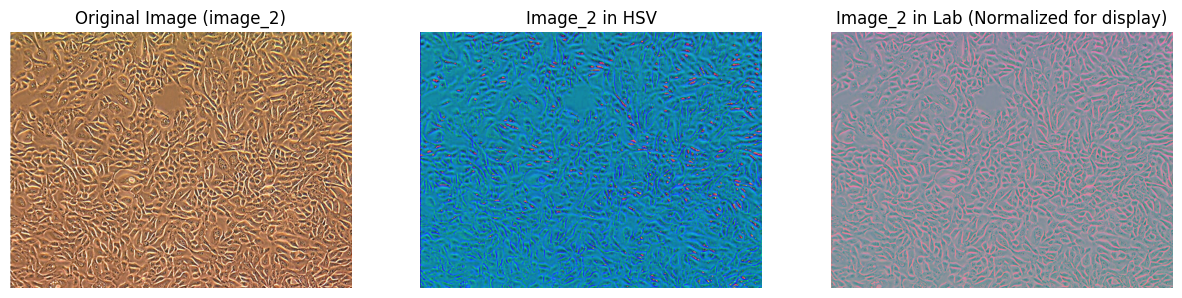

In [ ]:
import matplotlib.pyplot as plt
import skimage.color

# Convertimos la imagen a float para que la imagen esté entre 0 y 1 en vez de 0 a 255 porque hay que normalizar los valores para transformar a HSV y a Lab
image_2_float = skimage.img_as_float(image_2.copy())

# Convertimos la imagen a HSB y también a Lab
image_2_hsv = skimage.color.rgb2hsv(image_2_float)
image_2_lab = skimage.color.rgb2lab(image_2_float)

# Creamos una figura para mostrar las tres imágenes a la vez
plt.figure(figsize=(15, 5))

#Mostramos la imagen original
plt.subplot(1, 3, 1)
plt.imshow(image_2)
plt.title("Original Image (image_2)")
plt.axis('off')

#Mostramos la imagen en HSV
plt.subplot(1, 3, 2)
plt.imshow(image_2_hsv)
plt.title("Image_2 in HSV")
plt.axis('off')


#Lab tiene valores fuera del rango de 0 a 1, y por lo tanto necesitamos normalizarla porque si no la función imshow no la puede mostrar
image_2_lab_display = (image_2_lab + [0, 128, 128]) / [100, 255, 255]  #suma y divide los valores para que queden entre 0 y 1
image_2_lab_display = np.clip(image_2_lab_display, 0, 1) #asegura que los valores no se salgan del rango

#Mostramos la foto en Lab ajustada
plt.subplot(1, 3, 3)
plt.imshow(image_2_lab_display)
plt.title("Image_2 in Lab (Normalized for display)")
plt.axis('off')

plt.show() #Mostramos las tres imágenes

Preparamos las imágenes para el análisis:

In [ ]:
#Convertimos la imagen a float
image_2_float = skimage.img_as_float(image_2.copy())

# Propiedades de la imagen como altura, ancho o número de canales de la imagen
height_2, width_2, channels_2 = image_2_float.shape

#Convertimos los datos de píxeles en una tabla 2D
pixel_data_2_rgb = image_2_float.reshape((-1, channels_2))

# Convertimos la imagen en float a HSV
image_2_hsv = skimage.color.rgb2hsv(image_2_float)

#Convertimos los datos de los píxeles de esta imagen en HSV a una tabla en 2D
pixel_data_2_hsv = image_2_hsv.reshape((-1, 3))

# Convertimos la imagen en float a Lab
image_2_lab = skimage.color.rgb2lab(image_2_float)

# Convertimos los datos de los píxeles de esta imagen en una tabla de 2D
pixel_data_2_lab = image_2_lab.reshape((-1, 3))

#Mostramos cuántos píxeles tiene cada versión
print("Shapes:")
print(" RGB:", pixel_data_2_rgb.shape)
print(" HSV:", pixel_data_2_hsv.shape)
print(" Lab:", pixel_data_2_lab.shape)

Shapes:
 RGB: (786432, 3)
 HSV: (786432, 3)
 Lab: (786432, 3)


Ahora aplicamos el algoritmo KMeans en los datos de los píxeles de cada espacio de color (RGB,HSV y Lab) para poder segmentar las imágenes en clusters

In [ ]:
#Importamos KMeans y StandardScaler
from sklearn.cluster import KMeans #agrupa los píxeles por similitud de color
from sklearn.preprocessing import StandardScaler #para normalizar valores numéricos (importante en Lab)

#Clustering para la imagen en RGB
kmeans_2_rgb = KMeans(n_clusters=3, random_state=42, n_init=10)#cluster=3 para agrupar por 3 colores, randomstate 42 para iniciar siempre en el mismo lugar (en nuestro caso 42), y n init 10 para que se repita 10 veces desde 42 y elige la mejor
pixel_labels_2_rgb = kmeans_2_rgb.fit_predict(pixel_data_2_rgb) #cada píxel recibe una etiqueta de 0, 1 o 2 según el grupo al que pertenece

# Clustering para HSV
kmeans_2_hsv = KMeans(n_clusters=3, random_state=42, n_init=10)
pixel_labels_2_hsv = kmeans_2_hsv.fit_predict(pixel_data_2_hsv)

#Clustering para Lab pero usamos standardscaler para escalar los datos primero
scaler_2 = StandardScaler() #hay que normalizar porque L, a y b tienen rangos distintos
pixel_data_2_lab_scaled = scaler_2.fit_transform(pixel_data_2_lab)
kmeans_2_lab = KMeans(n_clusters=3, random_state=42, n_init=10)
pixel_labels_2_lab = kmeans_2_lab.fit_predict(pixel_data_2_lab_scaled)

# Mostramos el número de píxeles que tienen cada uno porque le hemos asignado una etiqueta a cada uno
print("RGB cluster labels shape:", pixel_labels_2_rgb.shape)
print("HSV cluster labels shape:", pixel_labels_2_hsv.shape)
print("Lab cluster labels shape:", pixel_labels_2_lab.shape)

RGB cluster labels shape: (786432,)
HSV cluster labels shape: (786432,)
Lab cluster labels shape: (786432,)


Ahora identificamos los clusteres de interés:

In [ ]:
# Los centros de cluster indican los colores promedio de los tres grupos
print("\nCluster Centers (RGB):")
print(kmeans_2_rgb.cluster_centers_)

print("\nCluster Centers (HSV):")
print(kmeans_2_hsv.cluster_centers_)

print("\nCluster Centers (Lab):")
print(kmeans_2_lab.cluster_centers_)


Cluster Centers (RGB):
[[0.68648705 0.4884596  0.33842835]
 [0.92656721 0.78467644 0.59436696]
 [0.47243329 0.31267924 0.21531535]]

Cluster Centers (HSV):
[[0.94554242 0.309135   0.41278973]
 [0.085822   0.42161869 0.85049724]
 [0.06727931 0.53291036 0.56284662]]

Cluster Centers (Lab):
[[ 1.59293559 -1.46296205  0.28411549]
 [ 0.03463165  0.51186241  0.4997891 ]
 [-0.83743362 -0.12929004 -0.96504262]]


In [ ]:
#RGB centers:
#Cluster 0: Closer to reddish-brown.
#Cluster 1: Closer to white/light color. (Borde celular)
#Cluster 2: Closer to a darker brown/grey.


Viendo los resultados que nos da el clustering en RGB, podemos ver que el cluster 1 tiene valores más cercanos al blanco o colores más claros. Entonces elegimos este como el borde de las células, porque en la imagen se ven blancos o más claros




In [ ]:
#HSV centers:
#Cluster 0: [0.945, 0.309, 0.412] - Hue near 1 (red/magenta wrap-around)
#Cluster 1: [0.085, 0.421, 0.850] - Hue near 0.08 (red/orange) (borde)
#Cluster 2: [0.067, 0.532, 0,562] - Hue near 0.06 (red/orange)

Viendo los resultados que nos da el clustering en HSV, elegimos el cluster 1 para definir aún más los bordes de las células

In [ ]:
#Lab centers:
#Cluster 0: [1.592, -1.462, 0.284] - Negative 'a', positive 'b'. Greenish/yellowish.
#Cluster 1: [0.034, 0.511, 0.499] - Positive 'a', positive 'b'. Reddish/yellowish. (color de fondo)
#Cluster 2: [-0.837, -0.129, -0.965] - Negative 'a', negative 'b'- Greenish/blueish


Viendo los resultados que nos da el clustering en Lab, elegimos el cluster 1 porque el color es más parecido al fondo

Seleccionamos los clusteres que hemos elegido manualmente:

In [ ]:

Borde_cluster_rgb = 1
Borde_cluster_hsv = 1
Fondo_cluster_lab = 1

#Imprimimos los clusters que hemos elegido:
print(f"Identified borde cluster (RGB): {Borde_cluster_rgb}")
print(f"Identified borde cluster (HSV): {Borde_cluster_hsv}")
print(f"Identified fondo cluster (Lab): {Fondo_cluster_lab}")

Identified borde cluster (RGB): 1
Identified borde cluster (HSV): 1
Identified fondo cluster (Lab): 1


A continuación, vamos a crear máscaras combinadas basadas en los clusters para obtener una máscara más robusta que represente las células:

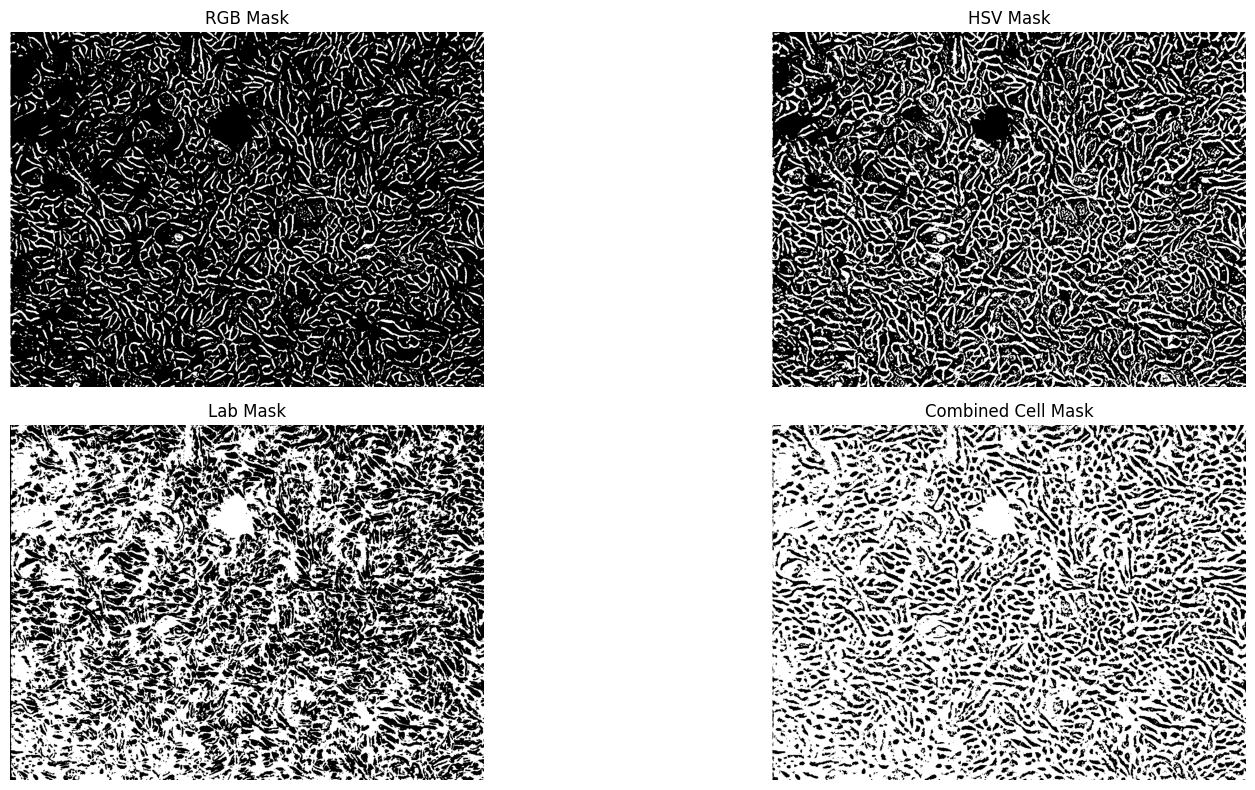

In [ ]:
import matplotlib.pyplot as plt #para mostrar imágenes
import numpy as np  #para hacer operaciones lógicas con matrices

# Creamos una máscara binaria para el cluster que hemos elegido de borde en RGB.
rgb_mask = (pixel_labels_2_rgb == Borde_cluster_rgb)

# La ajustamos a las dimensiones de la imagen original.
rgb_mask_reshaped = rgb_mask.reshape((height_2, width_2))

# Creamos una máscara binaria para el cluster que hemos elegido de borde para HSV.
hsv_mask = (pixel_labels_2_hsv == Borde_cluster_hsv)

# La ajustamos a las dimensiones de la imagen original.
hsv_mask_reshaped = hsv_mask.reshape((height_2, width_2))

# Creamos una máscara binaria para el cluster que hemos elegido de fondo en Lab.
lab_mask = (pixel_labels_2_lab == Fondo_cluster_lab)

# La ajustamos a las dimensiones de la imagen original.
lab_mask_reshaped = lab_mask.reshape((height_2, width_2))

# Combinamos las tres máscaras binarias.
combined_cell_mask = rgb_mask_reshaped | hsv_mask_reshaped | lab_mask_reshaped

# Mostramos las máscaras individuales y la combinada.
plt.figure(figsize=(18, 8))

plt.subplot(2, 2, 1)
plt.imshow(rgb_mask_reshaped, cmap='gray') #para mostrar en blanco y negro
plt.title("RGB Mask")
plt.axis('off')

plt.subplot(2, 2, 2)
plt.imshow(hsv_mask_reshaped, cmap='gray')
plt.title("HSV Mask")
plt.axis('off')

plt.subplot(2, 2, 3)
plt.imshow(lab_mask_reshaped, cmap='gray')
plt.title("Lab Mask")
plt.axis('off')

plt.subplot(2, 2, 4)
plt.imshow(combined_cell_mask, cmap='gray')
plt.title("Combined Cell Mask")
plt.axis('off')

plt.tight_layout()
plt.show()

Por último, usamos la máscara combinada para etiquetar los objetos y contar el número de regiones (células) detectadas:

/tmp/ipython-input-1663903694.py:12: FutureWarning: `square` is deprecated since version 0.25 and will be removed in version 0.27. Use `skimage.morphology.footprint_rectangle` instead.
  selem = skimage.morphology.square(4) # Tamaño 4x4


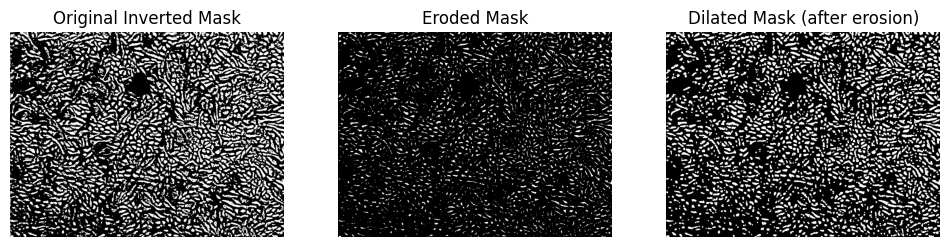

In [ ]:
import skimage.morphology #para hacer erosión, dilatación, apertura...
import matplotlib.pyplot as plt #para mostrar imágenes
import numpy as np #para operaciónes matemáticas

#invertimos la imagen
inverted_image_2 = 1 - combined_cell_mask
inverted_image_2_bool = inverted_image_2.astype(bool) #convertimos la imagen en booleano  porque algunas funciones de morfología solo funcionan con booleanos


# Define a structuring element (e.g., a square or disk)
# A small square is common
selem = skimage.morphology.square(4) # Tamaño 4x4

# Hacemos erosión para encoger un poco las zonas blancas y separar las que pudieran estar juntas ademas de eliminar posible ruido presente en el conteo.
eroded_image = skimage.morphology.binary_erosion(inverted_image_2_bool, footprint=selem)

# Hacemos dilatación después de erosión, que agranda las zonas blancas pero las mantiene separadas
dilated_image = skimage.morphology.binary_dilation(eroded_image, footprint=selem)

# Mostramos la imagen invertida, la erosionada y la dilatada después de la erosión
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.imshow(inverted_image_2, cmap='gray')
plt.title("Original Inverted Mask")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(eroded_image, cmap='gray')
plt.title("Eroded Mask")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(dilated_image, cmap='gray')
plt.title("Dilated Mask (after erosion)")
plt.axis('off')

plt.show()

Ahora que vemos las células mejor definidas, pasamos a detectar las zonas blancas (células):

Number of cells detected: 2172


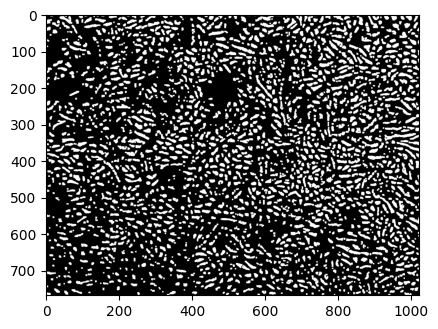

In [ ]:
# Se asigna un número a cada zona blanca (zona donde los pixeles blancos están conectados).
labeled_cells = skimage.measure.label(dilated_image)

# Para calcular las propiedades de cada zona blanca.
cell_properties = skimage.measure.regionprops(labeled_cells)

# Contamos cuantas regiones etiquetadas con un número hay
num_cells = len(cell_properties)

# Imprimimos el resultado
print(f"Number of cells detected: {num_cells}")
plt.figure(figsize=(18, 8))

plt.subplot(2, 2, 1)
plt.imshow(dilated_image, cmap='gray')

Visualizamos los resultados (rodeando las células con cajas):

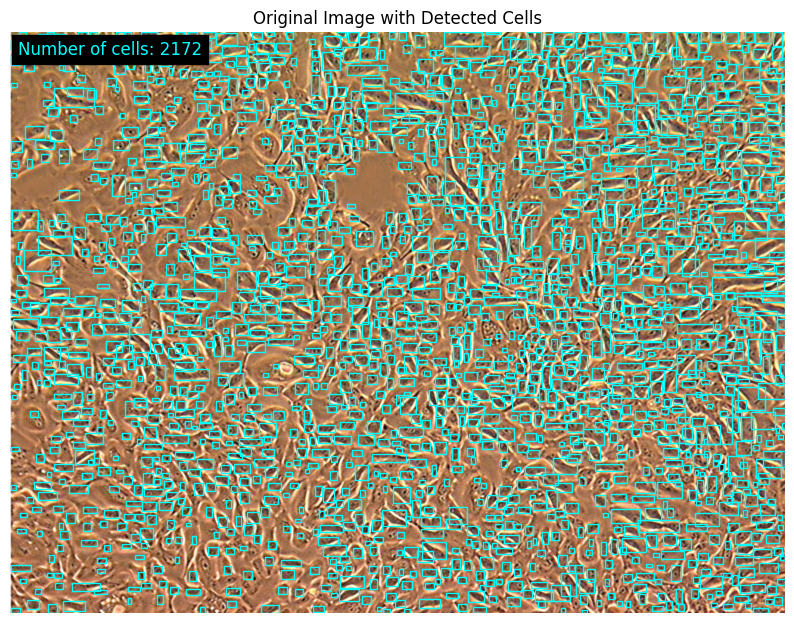

In [ ]:
import matplotlib.pyplot as plt #para mostrar imágenes
import matplotlib.patches as patches #para dibujar figuras sobre la imagen
import skimage.io #para leer imagenes desde un archivo

#Importar la imagen original otra vez
original_image_for_viz = skimage.io.imread('cell_skin.png')

plt.figure(figsize=(10, 10))
plt.imshow(original_image_for_viz)
plt.title("Original Image with Detected Cells")
plt.axis('off')

ax = plt.gca()

# Dibujar las cajas que rodean las células
for prop in cell_properties:
    # Filtramos pequeñas regiones que podrían ser confundidas por células
    if prop.area > 30: #ajustamos el área
        minr, minc, maxr, maxc = prop.bbox
        rect = patches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                 linewidth=1, edgecolor='cyan', facecolor='none') #propiedades de las cajas, como por ejemplo el color del borde o el relleno
        ax.add_patch(rect)

# Mostrar todas las células rodeadas por cajasDisplay the total number of cells
plt.text(10, 30, f'Number of cells: {num_cells}', color='cyan', fontsize=12, backgroundcolor='black')

plt.show()

Hemos conseguido observar todas las células rodeadas por cajas y el número de células totales